In [1]:
import os
# disable running on GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout, Input, Add, DepthwiseConv2D, Average, RepeatVector
from keras.layers import AveragePooling2D, Conv2D, BatchNormalization, MaxPooling2D, Lambda, SeparableConv2D, GRU, LSTM
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras.losses import mse, binary_crossentropy
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
import keras.backend as K
import h5py
import pandas as pd
import datetime
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import matplotlib.pyplot as plt

from random import shuffle
import random
import pickle
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import h5py
from IPython.display import clear_output

from tqdm import tqdm

from utils.datautils import *

from EvalGeneratorLSTM import WaveDataGeneratorExtended as WaveDataGeneratorExtended_eval
from TrainGeneratorLSTM import WaveDataGeneratorExtended as WaveDataGeneratorExtended_train

/home/zdeploy/.virtualenvs/dl-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/home/zdeploy/.virtualenvs/dl-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zdeploy/.virtualenvs/dl-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zdeploy/.virtualenvs/dl-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zdeploy/.virtualenvs/dl-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 9

In [2]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
set_session(tf.Session(config=config))

[82, 44, 52, 51, 58, 63, 43, 53, 62, 70, 51, 51, 56, 51, 50, 53, 71, 74, 43, 61, 51, 57, 41, 47, 53, 63]
[0, 2, 3, 4, 5, 7, 8, 9, 10, 13, 15, 16, 18, 21, 24, 26, 29, 31, 42, 44, 46, 47, 49, 50, 74, 85]
((26,), 'min:', 41, 'max:', 82, 'std:', 9.953813458512466, 'mean:', 55.80769230769231, 'median:', 53.0)
train sum: 1195


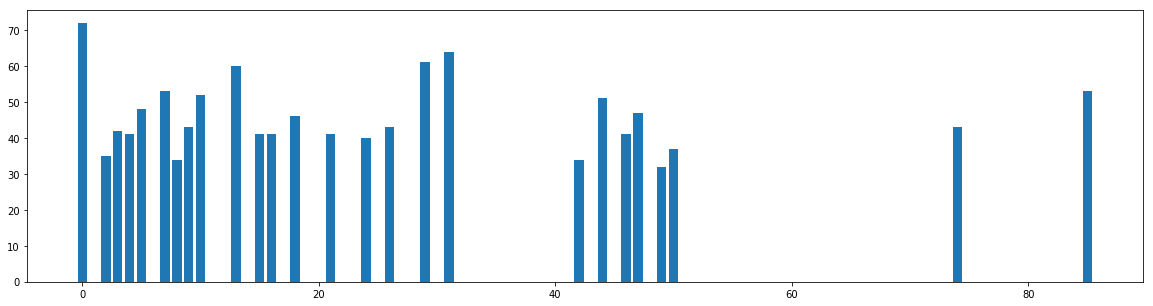

[72, 35, 42, 41, 48, 53, 34, 43, 52, 60, 41, 41, 46, 41, 40, 43, 61, 64, 34, 51, 41, 47, 32, 37, 43, 53]
[0, 2, 3, 4, 5, 7, 8, 9, 10, 13, 15, 16, 18, 21, 24, 26, 29, 31, 42, 44, 46, 47, 49, 50, 74, 85]
((26,), 'min:', 32, 'max:', 72, 'std:', 9.756578724243804, 'mean:', 45.96153846153846, 'median:', 43.0)
val sum: 256


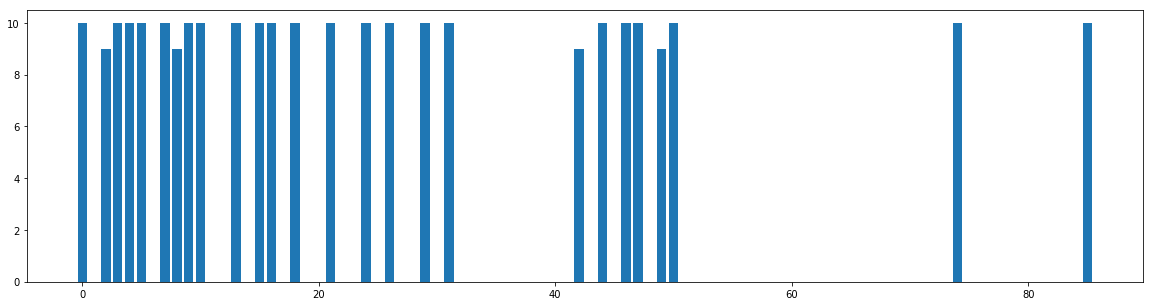

[10, 9, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 9, 10, 10, 10]
[0, 2, 3, 4, 5, 7, 8, 9, 10, 13, 15, 16, 18, 85, 24, 26, 29, 31, 42, 44, 46, 47, 49, 50, 74, 21]
((26,), 'min:', 9, 'max:', 10, 'std:', 0.36080121229410994, 'mean:', 9.846153846153847, 'median:', 10.0)


In [3]:
numpy_train_x, numpy_train_y = get_wave_pair('/data1/ZAVoiceChallenge/duydv2/user_embed/user_embeding_cut_3s')
train_x, train_y, val_x, val_y = split_data(numpy_train_x, numpy_train_y, alpha=0.8, maxx=10)
train_x_up, train_y_up = train_x, train_y

plt.figure(figsize=(20, 5))
_,_,_ = statistic_data(train_x_up, train_y_up, title='train')
plt.figure(figsize=(20, 5))
_,_,_ = statistic_data(val_x, val_y, title='val')

gen = WaveDataGeneratorExtended_train()

In [4]:
input_shape = (130, 80)
batch_size = 16

In [5]:
def build_model(input_shape, latent_dim=3, buffer_dim=36):
    time_step = input_shape[0]
    vect_dim = input_shape[1]
    
    # encode module
    x = Input(shape=input_shape)
    h = GRU(buffer_dim)(x)
    z_mean = Dense(latent_dim)(h)
    z_std = Dense(latent_dim)(h)
    
    # sampling module
    def re_sample(args):
        z_mean, z_std = args
        epsilon = K.random_normal_variable(shape=(batch_size, latent_dim), mean=0, scale=1)
        return z_mean + K.exp(z_std)*epsilon
    
    z = Lambda(re_sample, output_shape=(latent_dim,))([z_mean, z_std])
    
    # decode module
    decoder_h = Dense(buffer_dim)
    decoder_mean = LSTM(vect_dim, return_sequences=True)
    h_decoded = decoder_h(z)
    h_decoded_repeat = RepeatVector(time_step)(h_decoded)
    x_decoded = decoder_mean(h_decoded_repeat)
    
    # end-to-end autoencoder
    vae = Model(x, x_decoded)
    
    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)
    
    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    _h_decoded_repeat = RepeatVector(time_step)(_h_decoded)
    _x_decoded = decoder_mean(_h_decoded_repeat)
    generator = Model(decoder_input, _x_decoded)
    
    # loss function
    reconstruction_loss = binary_crossentropy(x, x_decoded)
    reconstruction_loss *= vect_dim*time_step
    kl_loss = 1 + z_std - K.square(z_mean) - K.exp(z_mean)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    
    # compile model
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    
    return vae, encoder, generator

In [6]:
vae, encoder, generator = build_model(input_shape)

In [7]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 130, 80)      0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 36)           12636       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3)            111         gru_1[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3)            111         gru_1[0][0]                      
__________________________________________________________________________________________________
lambda_1 (

In [8]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 130, 80)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 36)                12636     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 111       
Total params: 12,747
Trainable params: 12,747
Non-trainable params: 0
_________________________________________________________________


In [9]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 36)                144       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 130, 36)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 130, 80)           37440     
Total params: 37,584
Trainable params: 37,584
Non-trainable params: 0
_________________________________________________________________


In [10]:
aaaaa = gen.flow_from_json(numpy_train_x, numpy_train_y, batch_size=16, target_size=input_shape, color_mode='grayscale', class_mode=None)

Found 1451 images belonging to 26 classes.


In [11]:
for a in aaaaa:
    print(a.shape)
    break;

(16, 130, 80, 1)


In [12]:
hist = vae.fit_generator(gen.flow_from_json(train_x, train_y, batch_size=16, target_size=input_shape, color_mode='grayscale', class_mode=None), 
                           epochs=10, 
                           verbose=1, 
                           callbacks=callbacks_list, 
                           validation_data=gen.flow_from_json(val_x, val_y, batch_size=16, target_size=(314, 128), color_mode='grayscale'),
                           workers=20, 
                           use_multiprocessing=True, 
                           shuffle=True,
                           max_queue_size=20)

NameError: name 'model' is not defined